## Imports

In [95]:
import os, json, math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

## Paths and basic config

In [96]:
exercise = "Squats"
example_number = "3"

INPUT_VIDEO = f"../data/{exercise}/{example_number}.mp4"
MODEL_PATH = "pose_landmarker.task"

OUT_DIR = "../results"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_ANNOTATED = os.path.join(OUT_DIR, f"{exercise}/Example {example_number}/annotated_video.mp4")
OUT_METRICS_CSV = os.path.join(OUT_DIR, f"{exercise}/Example {example_number}/metrics.csv")
OUT_EVENTS_JSON = os.path.join(OUT_DIR, f"{exercise}/Example {example_number}/rep_events.json")
OUT_PLOT = os.path.join(OUT_DIR, f"{exercise}/Example {example_number}/signal_plot.png")

FRAME_STRIDE = 1
KNEE_SIDE = "RIGHT"

BaseOptions = python.BaseOptions
PoseLandmarker = vision.PoseLandmarker
PoseLandmarkerOptions = vision.PoseLandmarkerOptions
VisionRunningMode = vision.RunningMode

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=MODEL_PATH),
    running_mode=VisionRunningMode.IMAGE
)

landmarker = PoseLandmarker.create_from_options(options)

print("Ready.")
print("Input:", INPUT_VIDEO)
print("Outputs:", OUT_DIR)

Ready.
Input: ../data/Squats/3.mp4
Outputs: ../results


## Helper functions

In [97]:
def angle_degrees(a, b, c):
    ba = a - b
    bc = c - b
    denom = (np.linalg.norm(ba) * np.linalg.norm(bc)) + 1e-9
    cosang = np.dot(ba, bc) / denom
    cosang = np.clip(cosang, -1.0, 1.0)
    return float(np.degrees(np.arccos(cosang)))


In [98]:
def moving_average(x, win=7):
    x = np.asarray(x, dtype=np.float32)
    if win <= 1:
        return x
    win = int(win)
    pad = win // 2
    xpad = np.pad(x, (pad, pad), mode="edge")
    kernel = np.ones(win, dtype=np.float32) / win
    return np.convolve(xpad, kernel, mode="valid")

In [99]:
# PoseLandmarker indices (BlazePose 33 landmarks)
IDX = {
    "RIGHT": {"hip": 24, "knee": 26, "ankle": 28},
    "LEFT":  {"hip": 23, "knee": 25, "ankle": 27},
}

def knee_angle_from_landmarks(lms, w, h, side="RIGHT"):
    s = side.upper()
    hip = lms[IDX[s]["hip"]]
    knee = lms[IDX[s]["knee"]]
    ankle = lms[IDX[s]["ankle"]]

    a = np.array([hip.x * w, hip.y * h], dtype=np.float32)
    b = np.array([knee.x * w, knee.y * h], dtype=np.float32)
    c = np.array([ankle.x * w, ankle.y * h], dtype=np.float32)

    ang = angle_degrees(a, b, c)

    # Some builds expose visibility/presence, some not → safe access
    vis_vals = []
    for lm in (hip, knee, ankle):
        vis_vals.append(getattr(lm, "visibility", 1.0))
        vis_vals.append(getattr(lm, "presence", 1.0))
    vis_min = float(np.min(vis_vals)) if vis_vals else 1.0

    return ang, vis_min

In [ ]:
# BODY point connections
POSE_CONNECTIONS_BODY = [
    # Shoulders
    (11, 12),

    # Right arm
    (12, 14), (14, 16),
    (16, 18), (16, 20), (16, 22),

    # Left arm
    (11, 13), (13, 15),
    (15, 17), (15, 19), (15, 21),

    # Torso
    (11, 23), (12, 24), (23, 24),

    # Right leg
    (24, 26), (26, 28), (28, 30), (30, 32),

    # Left leg
    (23, 25), (25, 27), (27, 29), (29, 31),
]

# Connecting landmarks
def draw_pose_connections(frame, landmarks, w, h, connections=POSE_CONNECTIONS_BODY, point_radius=4, line_thickness=3):
    pts = []
    for lm in landmarks:
        x = int(lm.x * w)
        y = int(lm.y * h)
        pts.append((x, y))

    # Draw lines
    for a, b in connections:
        xa, ya = pts[a]
        xb, yb = pts[b]
        cv2.line(frame, (xa, ya), (xb, yb), (0, 255, 0), line_thickness)

    # Draw joints
    for idx, (x, y) in enumerate(pts):
        if idx >= 11:  # Skip face entirely (0–10)
            cv2.circle(frame, (x, y), point_radius, (0, 255, 0), -1)

    return frame

## Showing 1 annotated frame

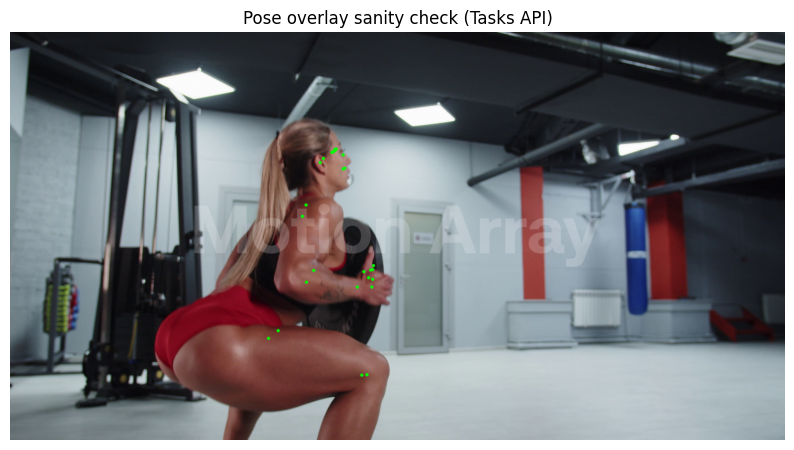

In [101]:
cap = cv2.VideoCapture(INPUT_VIDEO)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video: {INPUT_VIDEO}")

ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Could not read the first frame.")

H, W = frame.shape[:2]

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB,
                    data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

result = landmarker.detect(mp_image)

annot = frame.copy()
if result.pose_landmarks:
    for lm in result.pose_landmarks[0]:
        x = int(lm.x * W)
        y = int(lm.y * H)
        cv2.circle(annot, (x, y), 4, (0, 255, 0), -1)

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(annot, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Pose overlay sanity check (Tasks API)")
plt.show()

## Extracting per-frame knee angle signal

In [102]:
cap = cv2.VideoCapture(INPUT_VIDEO)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video: {INPUT_VIDEO}")

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

rows = []
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % FRAME_STRIDE != 0:
        frame_idx += 1
        continue

    t_sec = frame_idx / fps

    mp_image = mp.Image(
        image_format=mp.ImageFormat.SRGB,
        data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    )
    result = landmarker.detect(mp_image)

    if result.pose_landmarks and len(result.pose_landmarks) > 0:
        lms = result.pose_landmarks[0]
        knee_ang, vis = knee_angle_from_landmarks(lms, W, H, side=KNEE_SIDE)
        detected = 1
    else:
        knee_ang, vis, detected = np.nan, 0.0, 0

    rows.append({
        "frame": frame_idx,
        "time_sec": t_sec,
        "knee_angle_deg": knee_ang,
        "vis_min": vis,
        "pose_detected": detected
    })

    frame_idx += 1

cap.release()

df = pd.DataFrame(rows)
df["knee_angle_interp"] = df["knee_angle_deg"].interpolate(limit_direction="both")
df["knee_angle_smooth"] = moving_average(df["knee_angle_interp"].to_numpy(), win=7)

df.to_csv(OUT_METRICS_CSV, index=False)
print("Saved:", OUT_METRICS_CSV)
df.head()


Saved: ../results\Squats/Example 3/metrics.csv


,frame,time_sec,knee_angle_deg,vis_min,pose_detected,knee_angle_interp,knee_angle_smooth
0,0,0.000000,85.080666,0.745700,1,85.080666,90.512253
1,1,0.041667,89.532440,0.728762,1,89.532440,93.284294
2,2,0.083333,94.953506,0.681098,1,94.953506,95.632385
3,3,0.125000,108.777130,0.793956,1,108.777130,97.529114
4,4,0.166667,104.484932,0.813429,1,104.484932,99.988670


## Plotting signal

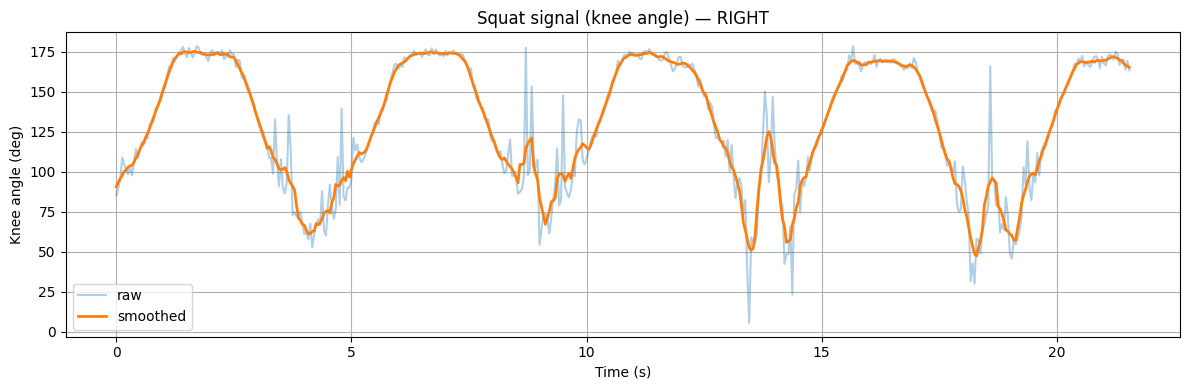

count    518.000000
mean     130.349121
std       37.519287
min       47.298553
25%      100.052319
50%      133.753494
75%      168.305553
max      175.165161
Name: knee_angle_smooth, dtype: float64


In [103]:
plt.figure(figsize=(12,4))
plt.plot(df["time_sec"], df["knee_angle_deg"], label="raw", alpha=0.35)
plt.plot(df["time_sec"], df["knee_angle_smooth"], label="smoothed", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Knee angle (deg)")
plt.title(f"Squat signal (knee angle) — {KNEE_SIDE}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(df["knee_angle_smooth"].describe())

## Rep counter

In [104]:
def count_reps_hysteresis(signal, time_sec, down_th, up_th, start_state="up", min_dt=0.5):
    state = start_state
    reps = 0
    states = []
    events = []
    last_rep_time = -1e9

    for x, t in zip(signal, time_sec):
        if state == "up":
            if x <= down_th:
                state = "down"
        else:
            if x >= up_th and (t - last_rep_time) >= min_dt:
                reps += 1
                last_rep_time = t
                events.append({"rep": reps, "time_sec": float(t)})
                state = "up"
        states.append(state)

    return reps, states, events

In [105]:
DOWN_TH = 115.0
UP_TH   = 155.0

reps, states, events = count_reps_hysteresis(
    df["knee_angle_smooth"].to_numpy(),
    df["time_sec"].to_numpy(),
    DOWN_TH, UP_TH
)

df["state"] = states
print("Reps counted:", reps)
print("First events:", events[:5])

with open(OUT_EVENTS_JSON, "w", encoding="utf-8") as f:
    json.dump({"exercise": "squat", "side": KNEE_SIDE, "down_th": DOWN_TH, "up_th": UP_TH, "events": events}, f, indent=2)
print("Saved:", OUT_EVENTS_JSON)

Reps counted: 5
First events: [{'rep': 1, 'time_sec': 1.0416666666666667}, {'rep': 2, 'time_sec': 5.833333333333333}, {'rep': 3, 'time_sec': 10.583333333333334}, {'rep': 4, 'time_sec': 15.416666666666666}, {'rep': 5, 'time_sec': 20.25}]
Saved: ../results\Squats/Example 3/rep_events.json


## Plotting signal + thresholds + rep events

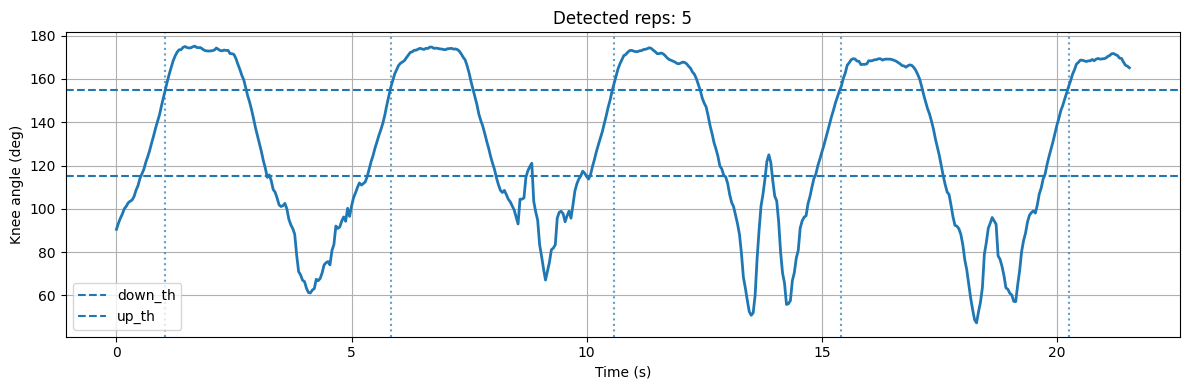

Saved plot: ../results\Squats/Example 3/signal_plot.png


In [106]:
plt.figure(figsize=(12,4))
plt.plot(df["time_sec"], df["knee_angle_smooth"], linewidth=2)
plt.axhline(DOWN_TH, linestyle="--", label="down_th")
plt.axhline(UP_TH, linestyle="--", label="up_th")
for e in events:
    plt.axvline(e["time_sec"], linestyle=":", alpha=0.7)

plt.xlabel("Time (s)")
plt.ylabel("Knee angle (deg)")
plt.title(f"Detected reps: {reps}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PLOT, dpi=200)
plt.show()

print("Saved plot:", OUT_PLOT)

## Rendering annotated video (skeleton + counter)

In [107]:
cap = cv2.VideoCapture(INPUT_VIDEO)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video: {INPUT_VIDEO}")

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(OUT_ANNOTATED, fourcc, fps, (W, H))

event_times = np.array([e["time_sec"] for e in events], dtype=np.float32) if events else np.array([], dtype=np.float32)

frame_idx = 0
rep_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    t_sec = frame_idx / fps

    while rep_count < len(event_times) and t_sec >= event_times[rep_count]:
        rep_count += 1

    mp_image = mp.Image(
        image_format=mp.ImageFormat.SRGB,
        data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    )
    result = landmarker.detect(mp_image)

    # Drawing skeleton landmarks + connections
    if result.pose_landmarks:
        draw_pose_connections(frame, result.pose_landmarks[0], W, H)


    # Overlay rep count
    cv2.rectangle(frame, (10, 10), (320, 90), (0, 0, 0), -1)
    cv2.putText(frame, f"Exercise: Squat ({KNEE_SIDE})", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(frame, f"Reps: {rep_count}", (20, 75),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2, cv2.LINE_AA)

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()

print("Saved annotated video:", OUT_ANNOTATED)

Saved annotated video: ../results\Squats/Example 3/annotated_video.mp4


## Closing landmarker

In [108]:
landmarker.close()
print("Landmarker closed.")

Landmarker closed.
